# DEG : pyDeseq2 & edgeR & MAST
- 대충 : pyDeseq2
- cell cluster끼리 DEG : edgeR & MAST

In [33]:
# Basic pipeline
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import loompy as lp
import sc_toolbox

# Model
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from scipy.sparse import csr_matrix, issparse
import gseapy as gp
from gseapy.plot import gseaplot
from gseapy import Biomart

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
from sanbomics.tools import id_map
from sanbomics.plots import volcano


# R integration
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

# adjunctive python library
import os
import random
from pprint import pprint
import warnings

warnings.filterwarnings(action='once')

%matplotlib inline
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)
sc.logging.print_header()

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.5 pynndescent==0.5.12
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3257793925.py:48: DeprecationWarning: The global conversion available with a

In [3]:
%%R
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(MAST))

In [4]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output'
deg_out_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output/deg'

In [ ]:
# Mutant vs Control
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))

In [17]:
adata.X = adata.layers['counts'].copy()

#### 0. Data prep
- `SAMPLE` : Control vs Mutant
- `label` : OPC/COP vs Tumor (비교하려는 cell type)
- `cell_type` : annotation

다시생각해보니
- `label` : ctrl vs mutant 인지
- `replicate` : LGG 1,2,3 느낌
- `sample` : replicate + label

In [9]:
# map SAMPLE - 조건에 상관없이
def sample_mapper(x):
    if x != "Control":
        return "Mutant"
    else:
        return x
adata.obs['SAMPLE'] = adata.obs.sample_id.map(lambda x: sample_mapper(x))

In [11]:
adata.obs.cell_type.value_counts()

cell_type
Tumor               14948
Oligodendrocyte      2110
Microglia            1106
OPC                   944
Astrocyte             832
NSC                   431
COP                   178
Endothelial_cell      173
Pericyte              165
Ependymal_cell        119
Neuron                 96
T-cell                 70
Name: count, dtype: int64

In [12]:
# map LABEL - 조건에 맞게 바꿔줘야함
compare = ["Oligodendrocyte", "OPC", "COP"] # 3232 vs 14948
def label_mapper(x):
    if x in compare:
        return "Nontumor"
    elif x == "Tumor":
        return "Tumor"
    else:
        return x
adata.obs['LABEL'] = adata.obs.cell_type.map(lambda x: label_mapper(x))

In [29]:
# 조건에 맞는 adata return
cond = adata.obs.LABEL.isin(["Tumor", "Nontumor"])
ddata = adata[cond,:]

#### 1. Run Deseq2
- 2 factor 분석 어떻게하지?

In [53]:
# create pseudobulk & replicates
def do_pseudobulk1(adata): # mutant vs control
    pseudobulk = []
    for sample in adata.obs.SAMPLE.unique():
        sample_cell_subset = adata[adata.obs['SAMPLE'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset.X.sum(axis = 0), 
                                var = sample_cell_subset.var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]
  
            rep_adata.obs['LABEL'] = sample_cell_subset.obs.LABEL.iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
            
    pb = sc.concat(pseudobulk)
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['LABEL'],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'LABEL', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

In [73]:
# create pseudobulk & replicates
def do_pseudobulk2(adata): # normal cell vs tumor cell
    pseudobulk = []
    for sample in adata.obs.LABEL.unique():
        sample_cell_subset = adata[adata.obs['LABEL'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset.X.sum(axis = 0), 
                                var = sample_cell_subset.var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]
  
            rep_adata.obs['LABEL'] = sample_cell_subset.obs.LABEL.iloc[0]
            rep_adata.obs['SAMPLE'] = sample_cell_subset.obs.SAMPLE.iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
            
    pb = sc.concat(pseudobulk)
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['LABEL', 'SAMPLE'],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'LABEL', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

In [74]:
dds, de, fig = do_pseudobulk2(ddata)

ValueError: Factors should take at least two values, but SAMPLE takes the single value '['Mutant']'.

In [55]:
mapper = id_map(species='mouse')
def map_ids(gene):
    if gene in mapper.mapper.keys():
        return mapper.mapper[gene]
    else:
        return gene
de["Symbol"] = de.index.map(map_ids)

de = de[de.baseMean >= 10]
sigs = de[(de.padj < 0.05) & (abs(de.log2FoldChange) > 1)]
sigs

/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1183966553.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/sanbomics/data/mouse_ids.csv'>
  mapper = id_map(species='mouse')


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Rgs20,1681.103814,1.493651,0.082271,18.155245,1.167066e-73,1.097235e-72,Rgs20
St18,23691.352346,-3.237092,0.012506,-258.842005,0.000000e+00,0.000000e+00,St18
Gm26901,123.217226,1.926548,0.340657,5.655388,1.554947e-08,4.495621e-08,Gm26901
Rrs1,1104.230672,1.207841,0.094591,12.769146,2.438154e-37,1.518726e-36,Rrs1
Adhfe1,118.345463,2.564966,0.416951,6.151723,7.664553e-10,2.366699e-09,Adhfe1
...,...,...,...,...,...,...,...
mt-Nd3,7808.790380,-1.546053,0.023033,-67.123864,0.000000e+00,0.000000e+00,mt-Nd3
mt-Nd4l,2064.722738,-1.324645,0.045605,-29.045928,1.732231e-185,2.843537e-184,mt-Nd4l
mt-Nd6,956.898601,-1.173326,0.067927,-17.273419,7.458911e-67,6.616155e-66,mt-Nd6
ENSMUSG00000095041,3822.384640,2.142837,0.064945,32.994797,9.645106e-239,1.844839e-237,AC149090.1


In [56]:
bm = Biomart()
h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])
library = gp.get_library('GO_Biological_Process_2023')
h2m_dict = {}
for i, row in h2m.loc[:,["external_gene_name", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict[row['external_gene_name']] = row["mmusculus_homolog_associated_gene_name"]

gene_sets = {}
for term, genes in library.items():
    new_genes = []
    for gene in genes:
        if gene in h2m_dict:
            new_genes.append(h2m_dict[gene])
    gene_sets[term] = new_genes

In [57]:
rnk = de[['stat']].dropna().sort_values('stat', ascending=False)
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets)

2024-05-17 03:54:44,654 [WARNING] Duplicated values found in preranked stats: 9.75% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [58]:
out = []
for term in list(pre_res.results):
    out.append([term, pre_res.results[term]['fdr'], pre_res.results[term]['es'], pre_res.results[term]['nes'],])
out_df = pd.DataFrame(out, columns=['term', 'fdr', 'Enrichment_Score', 'Normalized_Enrichment_Score', ]).sort_values('fdr').reset_index(drop=True)
out_df

,term,fdr,Enrichment_Score,Normalized_Enrichment_Score
0,Macromolecule Biosynthetic Process (GO:0009059),0.0,0.769593,2.969437
1,Translation (GO:0006412),0.0,0.754706,3.178499
2,Peptide Biosynthetic Process (GO:0043043),0.0,0.833856,3.228974
3,Cytoplasmic Translation (GO:0002181),0.0,0.927651,3.240920
4,Gene Expression (GO:0010467),0.0,0.651688,2.699562
...,...,...,...,...
2210,Transition Metal Ion Transport (GO:0000041),1.0,-0.851226,-1.736599
2211,Hexose Biosynthetic Process (GO:0019319),1.0,-0.203272,-0.418441
2212,Protein Localization To Cilium (GO:0061512),1.0,-0.209977,-0.439394
2213,Regulation Of Cytosolic Calcium Ion Concentrat...,1.0,-0.197521,-0.419850


In [43]:
import json

def get_existing_terms(terms, go_dicts):
    result = {}
    for category, go_dict in go_dicts.items():
        for term, go_id in go_dict.items():
            for s in terms:
                if term.lower() in s.lower():
                    result[s] = {
                        "Class": category,
                        "Subclass": term
                    }
    return result

terms = pre_res.res2d.Term

with open("../go_terms.json", "r") as json_file:
    jiehoon_terms = json.load(json_file)

existing_terms = get_existing_terms(terms, jiehoon_terms)
len(existing_terms.keys())

187

In [ ]:
# save to pdf
filename = 'scenario1'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.image import AxesImage
import io

with PdfPages(f'../plot/{filename}.pdf') as pdf:
    for i in range(0, len(existing_terms), 4):
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))
        
        axs = axs.flatten()
        
        # Iterate over the next 4 terms
        for j in range(4):
            if i + j < len(existing_terms):
                t = [k for k in existing_terms][i + j]
                
                plt.figure()
                pre_res.plot(terms=t)
                
                buf = io.BytesIO()
                plt.savefig(buf, format='png')
                plt.close()
                
                buf.seek(0)
                img = plt.imread(buf)
                axs[j].imshow(img)
                axs[j].set_title(f"Term: {existing_terms[t]['Class']} \n {existing_terms[t]['Subclass']}")
                axs[j].axis('off')
                
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

In [59]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_sigs = dds[:, sigs.index]
df_graph = pd.DataFrame(dds_sigs.layers['log1p'].T, index = dds_sigs.var_names, columns = dds_sigs.obs_names)

/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


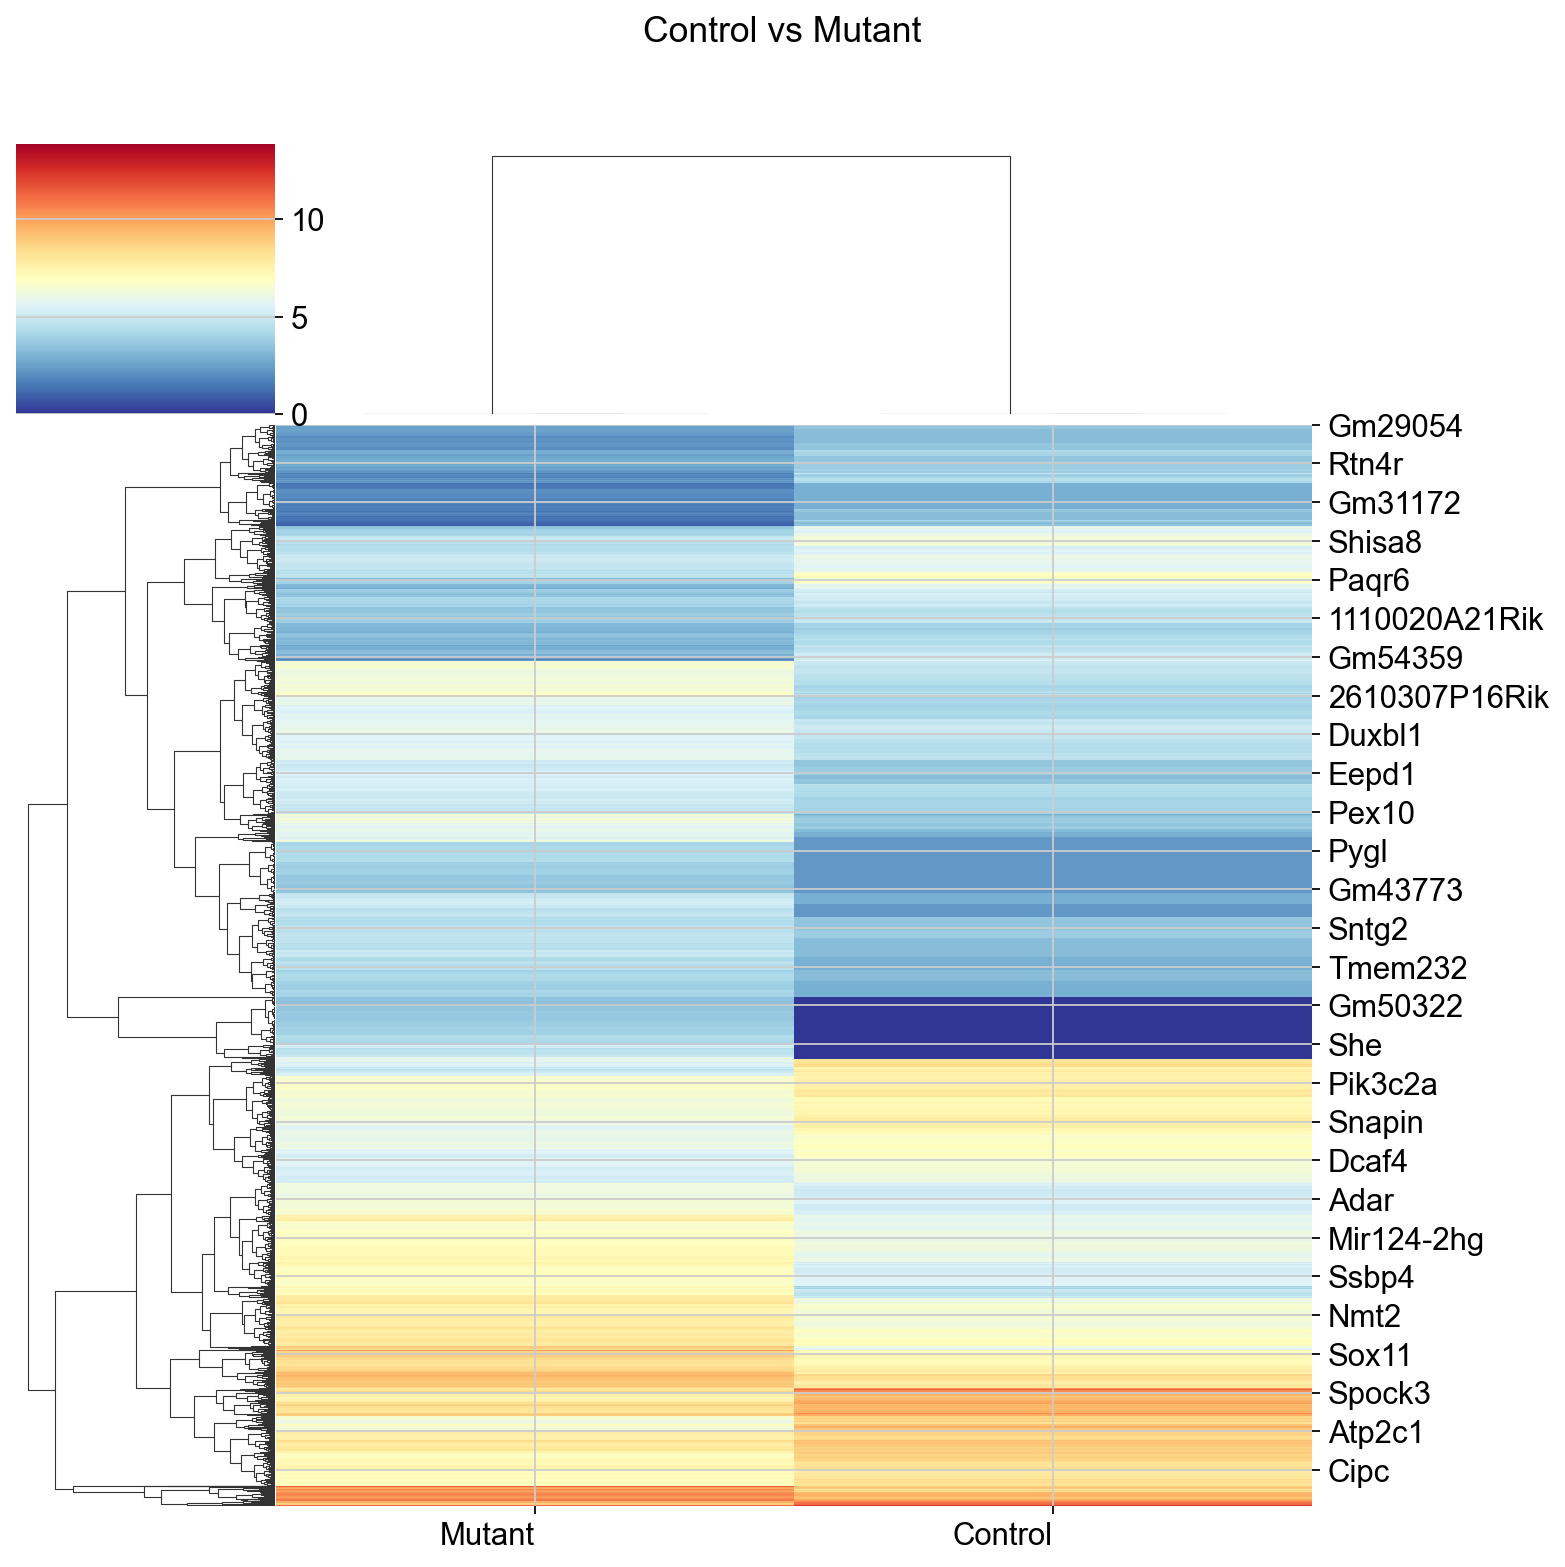

In [48]:
title = "Control vs Mutant"

g = sns.clustermap(df_graph, cmap = "RdYlBu_r",  method='average') 
unique_labels = ["Mutant", "Control"]
positions = [1.5, 4.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle(title, x=0.5, ha='center', fontsize=16)
plt.show()

In [68]:
markers_from_paper = pd.read_csv('../astrocytoma_markers.csv')
for col in markers_from_paper.columns:
    markers_from_paper[col] = markers_from_paper[col].apply(lambda x:x.capitalize())
markers_from_paper = {cell : [m for m in mk if m in adata.var.index] for cell, mk in markers_from_paper.items()}
markers_from_paper.keys()

g = sns.clustermap(df_sub, method='average', figsize = (4,4))
unique_labels = ["HGG", "Control"]
positions = [1.5, 4.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmap of OPC-like marker genes of HGG vs Control", x=0.5, ha='center', fontsize=11)
plt.show()

,Mutant-0,Mutant-1,Mutant-2,Control-0,Control-1,Control-2
Rgs20,7.816871,7.816871,7.816871,6.782283,6.782283,6.782283
St18,8.421650,8.421650,8.421650,10.665235,10.665235,10.665235
Gm26901,5.278673,5.278673,5.278673,3.957475,3.957475,3.957475
Rrs1,7.340988,7.340988,7.340988,6.504626,6.504626,6.504626
Adhfe1,5.315539,5.315539,5.315539,3.561520,3.561520,3.561520
...,...,...,...,...,...,...
mt-Nd3,8.290268,8.290268,8.290268,9.361745,9.361745,9.361745
mt-Nd4l,7.072638,7.072638,7.072638,7.990303,7.990303,7.990303
mt-Nd6,6.378256,6.378256,6.378256,7.190599,7.190599,7.190599
ENSMUSG00000095041,8.737826,8.737826,8.737826,7.253073,7.253073,7.253073


0s encountered for p value, imputing 1e-323
impute your own value if you want to avoid this


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/sanbomics/plots.py:94: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[pvalue][df[pvalue] == 0] = 1e-323
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/sanbo

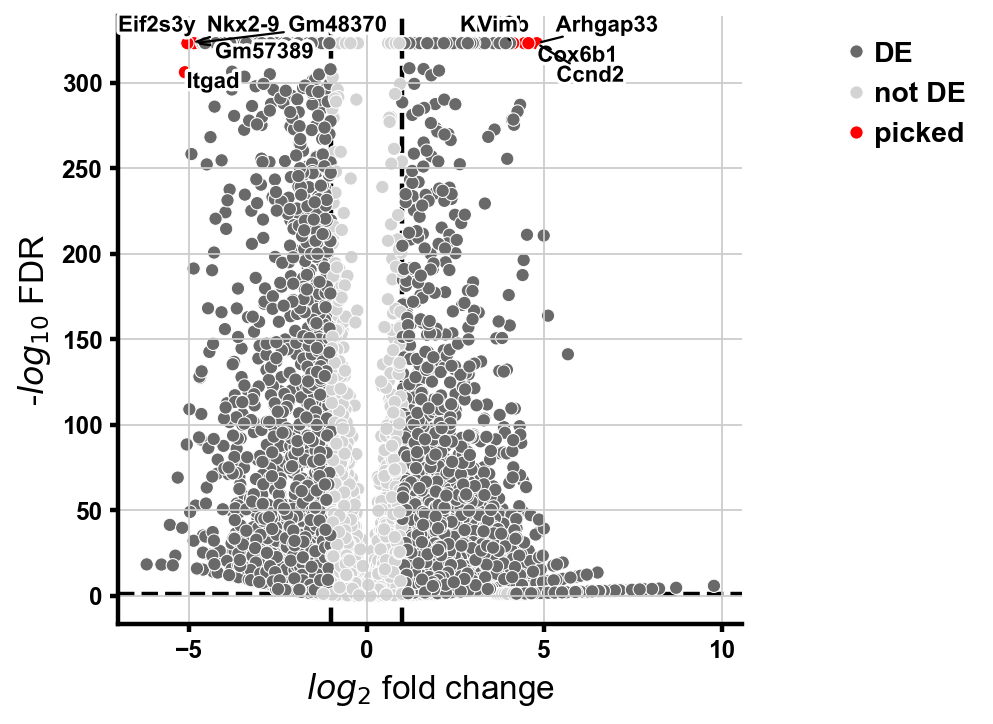

In [70]:
volcano(de, symbol="Symbol", log2fc_thresh = 1,  colors = ["dimgrey", "lightgrey", "red"])

#### 2. Run edgeR
- quasi-likelihood GLMs
- on specific-cell types

In [75]:
NUM_OF_CELL_PER_DONOR = 30
def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="SAMPLE",
    condition_key="LABEL",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1, 
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [76]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$LABEL)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is a concatenation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$LABEL, ".", colData(adata_)$cell_type)
    
    # uncomment later
    # replicate <- colData(adata_)$replicate
    
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    
    # uncomment for multifactor
    #design <- model.matrix(~ 0 + group + replicate)
    design <- model.matrix(~ 0 + group)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [77]:
ddata.X = ddata.layers["counts"].copy()

In [78]:
obs_to_keep = ["LABEL", "cell_type", "SAMPLE"]

In [79]:
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)

Processing Astrocyte (1 out of 12)...


In [80]:
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)




Processing COP (2 out of 12)...
Dropping the following samples:
['Control']


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)




Processing Endothelial_cell (3 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Processing Ependymal_cell (4 out of 12)...
Dropping the following samples:
['Control']


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)




Processing Microglia (5 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Processing NSC (6 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Processing Neuron (7 out of 12)...
Dropping the following samples:
['Control']


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)




Processing OPC (8 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Processing Oligodendrocyte (9 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Processing Pericyte (10 out of 12)...
Dropping the following samples:
['Control']


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)




Processing T-cell (11 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Dropping the following samples:
['Control']


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)




Processing Tumor (12 out of 12)...


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


Dropping the following samples:
['Control']


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/3934221099.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_295/1444409264.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_cell_type)


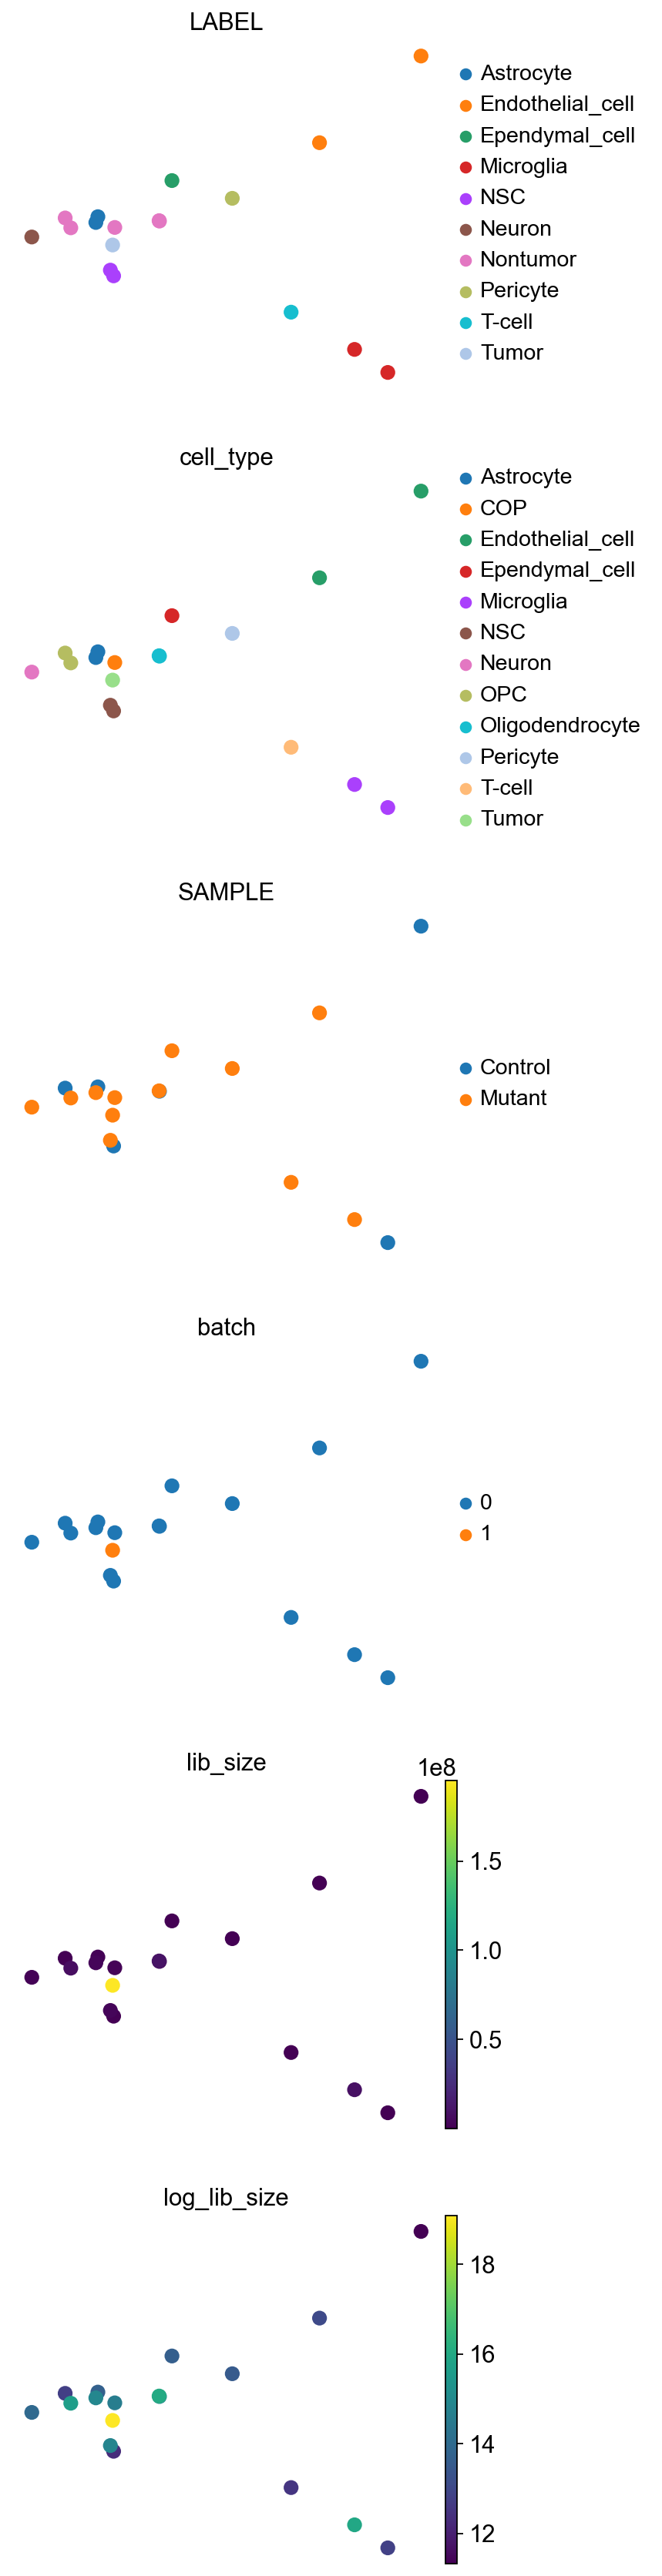

In [81]:
adata_pb.X = csr_matrix(adata_pb.X.astype(np.float64))
adata_pb.layers['counts'] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1).astype(float)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].values)
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [82]:
adata_pb.obsm['X_pca'] = csr_matrix(adata_pb.obsm['X_pca'])
adata_pb.X = adata_pb.layers['counts'].copy()
adata_pb.obs["cell_type"] = [ct.replace("-", "_") for ct in adata_pb.obs["cell_type"]]

In [83]:
%%R -i adata_pb
outs <-fit_model(adata_pb)

[1] "Dimensions before subsetting:"
[1] 33697    18
[1] ""
[1] "Dimensions after subsetting:"
[1] 15627    18
[1] ""


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of py2rpy in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/functools.py:889: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  return dispatch(args[0].__class__)(*args, **kw)


In [84]:
%%R
fit <- outs$fit
y <- outs$y

In [85]:
%%R
colnames(y$design)

 [1] "groupAstrocyte.Astrocyte"              
 [2] "groupEndothelial_cell.Endothelial_cell"
 [3] "groupEpendymal_cell.Ependymal_cell"    
 [4] "groupMicroglia.Microglia"              
 [5] "groupNSC.NSC"                          
 [6] "groupNeuron.Neuron"                    
 [7] "groupNontumor.COP"                     
 [8] "groupNontumor.OPC"                     
 [9] "groupNontumor.Oligodendrocyte"         
[10] "groupPericyte.Pericyte"                
[11] "groupT-cell.T_cell"                    
[12] "groupTumor.Tumor"                      


In [192]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # Check if cell_type is not NULL
    if (!is.null(cell_type) &&
        paste0('groupLGG.', cell_type) %in% colnames(y$design) && 
        paste0('groupControl.', cell_type) %in% colnames(y$design)) {
        myContrast <- makeContrasts(paste0("groupLGG.", cell_type, "-groupControl.", cell_type), levels = y$design)
        # Perform QLF test
        qlf <- glmQLFTest(fit, contrast=myContrast)
        # Get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
        tt <- topTags(qlf, n = Inf)
        # Save in the list with the results for all the cell types
        de_per_cell_type[[cell_type]] <- tt$table
    }
}

[1] "Astrocyte"
[1] "COP"
[1] "Endothelial_cell"


/Users/jiehoonk/micromamba/envs/sc/lib/python3.10/functools.py:889: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  return dispatch(args[0].__class__)(*args, **kw)


[1] "Ependymal_cell"
[1] "Microglia"
[1] "NSC"
[1] "Neuron"
[1] "OPC"
[1] "OPC_like"
[1] "Oligodendrocyte"
[1] "Pericyte"
[1] "Tumor"


In [193]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv((deg_out_path, f"de_edgeR_{cell_type}.csv"))

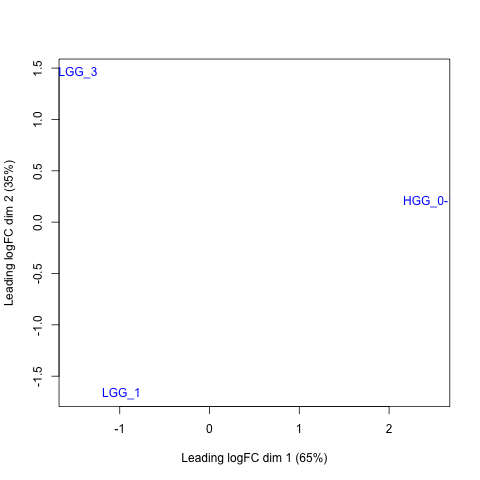

In [136]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

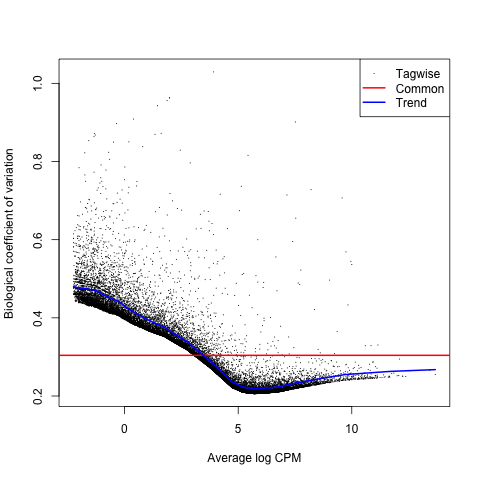

In [137]:
%%R
plotBCV(y)

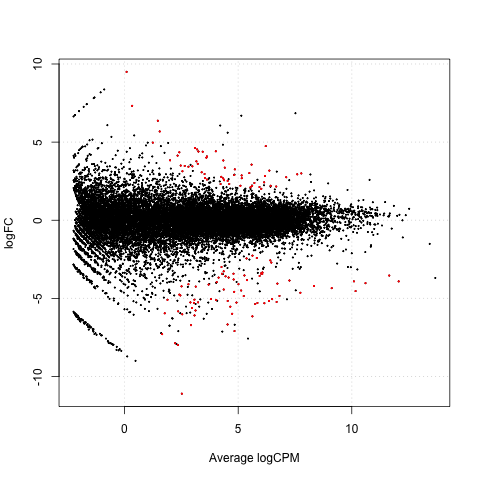

In [144]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

#### 3. Run MAST
- single cell specific

In [87]:
ddata.X = ddata.layers['counts'].copy()

In [88]:
sc.pp.normalize_total(ddata, target_sum=1e6)
sc.pp.log1p(ddata)

/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [89]:
def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

In [92]:
ddata_tumor = ddata[ddata.obs.LABEL == "Tumor"].copy()

In [94]:
sc.pp.filter_genes(ddata_tumor, min_cells=3)

In [95]:
ddata_tumor = prep_anndata(ddata_tumor)

In [ ]:
%%R
find_de_MAST_RE <- function(adata_){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    LABEL <- factor(colData(sca)$LABEL)
    # set the reference level
    LABEL <- relevel(LABEL,"ctrl")
    colData(sca)$LABEL <- LABEL
    celltype <- factor(colData(sca)$cell_type)
    colData(sca)$celltype <- celltype
    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$replicate)
    colData(sca)$replicate <- replicate
    # create a group per condition-celltype combination
    colData(sca)$group <- paste0(colData(adata_)$LABEL, ".", colData(adata_)$cell_type)
    colData(sca)$group <- factor(colData(sca)$group)
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in    
    summaryCond <- summary(zlmCond, doLRT='groupstim.CD14_Monocytes')
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

In [ ]:
%%time
%%R -i adata_mono -o res
res <-find_de_MAST_RE(adata_mono)


In [ ]:
res["gene_symbol"] = res["primerid"]
res["cell_type"] = "CD14_Monocytes"
sc_toolbox.tools.de_res_to_anndata(
    adata,
    res,
    groupby="cell_type",
    score_col="coef",
    pval_col="Pr(>Chisq)",
    pval_adj_col="FDR",
    lfc_col="coef",
    key_added="MAST_CD14_Monocytes",
)

In [ ]:
adata_copy = adata.copy()


#### 4. Visualize

In [145]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [207]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, group_key, group_name="cell_type", groupby="label"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
    )
    
def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()


In [204]:
adata.uns.keys()

dict_keys(['GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'copykat.pred_colors', 'dea_leiden_res3', 'dendrogram_cnv_leiden', 'dendrogram_leiden_res3', 'jw_anno_colors', 'leiden', 'leiden_res3_colors', 'mod_cell_type_colors', 'neighbors', 'over_colors', 'rank_genes_groups', 'sample_id_colors', 'umap', 'log1p', 'edgeR_Astrocyte', 'edgeR_Endothelial_cell', 'edgeR_Microglia', 'edgeR_NSC', 'edgeR_OPC', 'edgeR_Oligodendrocyte'])

Plotting 0 genes...


... storing 'label' as categorical


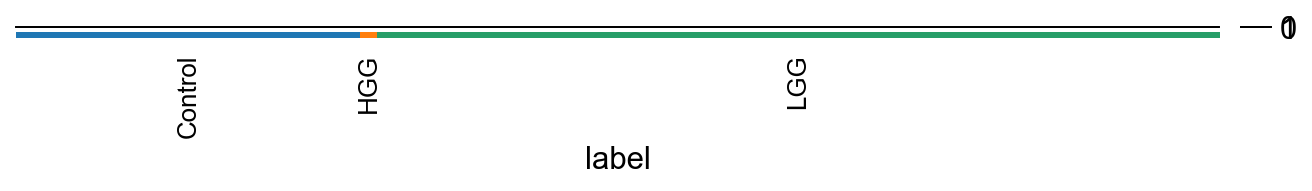

In [206]:
plot_heatmap(adata, 'edgeR_Oligodendrocyte')